# Developing a Portable Machine Learning Framework from Scratch

_An overview of the results of adding OpenCL to the simple_ml framework_

## Introduction

### Motivation

[OpenCL](https://www.khronos.org/opencl/), or Open Computing Language, is an
open standard maintained by a consortium of major software and hardware
companies, including AMD, ARM, Intel, and Nvidia, among others. Compared to
code that uses the proprietary [CUDA framework](https://developer.nvidia.com/cuda-toolkit)
which can only run Nvidia’s hardware, code written for OpenCL can run on
heterogeneous platforms, including CPUs, GPUs, DSPs, FPGAs, and other platforms
with OpenCL drivers.

<a href="https://www.khronos.org/opencl/">
<img src="https://developer.nvidia.com/sites/default/files/styles/main_image/public/akamai/cuda/images/OpenCL_RGB_500px_Apr20.png" alt="OpenCL Logo" style="width: 25%;  display: block; margin-left: auto; margin-right: auto;"/>
</a>
 
OpenCL’s portability and platform-agnosticism are desirable to deep-learning
developers who intend to train their models on non-NVIDIA hardware or whose
applications require intensive client-side computation. It’s also worth noting
that as cryptocurrency mining has been driving up costs of newer NVIDIA GPUs,
developers with a tight budget constraint, may find it helpful to be able to
train their models on hardware that cannot target CUDA. Since computation for
training deep neural networks can be highly accelerated with parallelization,
budget-constrained developers can expect a high return on investment from AMD
hardware from a few years ago even when compared to the state-of-the-art CPUs
from today.

`simple_ml` is a custom backend agnostic machine learning framework that is modeled
off of the same architecture as PyTorch. This framework was developed over the
[course of a semester](https://dlsyscourse.org/) in order to learn how machine
learning frameworks work as close to bare metal as possible. The base
implementation includes features such as auto-differentiation; NDArray and
Tensor operations; and neural network optimizer methods, activation functions,
and layers.

### Goal

This particular blog post will cover the API differences between CUDA
and OpenCL and detail the implementation of OpenCL for the `simple_ml` framework. The
goal was to achieve parity with the baseline functionality that was already
established with the CPU and CUDA backend implementations. As a bonus, we aimed
to port the im2col implementation of convolution from the Python layer code to
the backend targets (CPU, CUDA, OpenCL). Once these implementations had been
completed, the next target was to to benchmark each of the implementations
against one another on an NVIDA GPU to which we had access through Google Colab.

## Project Setup

The `simple_ml` framework behind the project can be [downloaded here](https://drive.google.com/drive/folders/1qJFxg1tt4Dy_0CnUAzkntKGdMO7spSkg?usp=sharing). Note that opencl is already installed in the Google Colab environment and we simply need to install the `C++` headers. We also install [`pybind11`](https://github.com/pybind/pybind11) into the environment which allows us to be able to _bind_ the `C++` implementation of functions to their `Python` counterparts.

<div class="alert alert-warning">
<b>Note:</b> These files are currently restricted to <code>*@andrew.cmu.edu</code> email domains only.
</dev>

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/10714/final_project
# !pip3 install pybind11
# !sudo apt-get install opencl-headers -y

### Compililation

The Google Drive folder above already contains compiled binaries that run on Google Colab. If you encounter a problem, try compiling again here.

One additional contribution to note here was the configuration of the `CMakeLists.txt` to all for compilation of both the CUDA and OpenCL bindings at the same time. Some challenges were encountered where the `CUDA` installation was _shadowing_ the OpenCL installation since CUDA ships with OpenCL headers as well. These issues are carefully resolved in the `CMakeLists.txt` configuration.

In [13]:
# !cd ..; make
# !make

### Package Imports

Note that we add the python and apps folders into the `PATH` here since they are not sibling modules and will not resolve properly using `Python`'s built in import resolution system.

In [4]:
# %set_env PYTHONPATH ./python
# 
# import sys
# sys.path.append('../python')
# sys.path.append('../apps')

env: PYTHONPATH=./python


In [7]:
import simple_ml as sm
from simple_ml import backend_ndarray as nd
from apps import ResNet9, ResNet94, train_cifar10, evaluate_cifar10

In [8]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

## Demonstration

The below are a couple of quick sanity checks to demonstrate that the opencl backend is actually executing simple array and matrix operations.

Let $$A = \begin{bmatrix}
1 & 2 \\
3 & 4
\end{bmatrix}
\quad
B = \begin{bmatrix}
5 & 6 \\
7 & 8
\end{bmatrix}$$

In [4]:
a = nd.array([[1, 2], [3, 4]], device=nd.opencl())
b = nd.array([[5, 6], [7, 8]], device=nd.opencl())

$$A + B = \begin{bmatrix}
6 & 8 \\
10 & 12
\end{bmatrix}$$

In [5]:
a + b

NDArray([[ 6.  8.]
 [10. 12.]], device=opencl())

$$A - B = \begin{bmatrix}
-4 & -4 \\
-4 & -4
\end{bmatrix}$$

In [6]:
a - b

NDArray([[-4. -4.]
 [-4. -4.]], device=opencl())

The following operation denote elemtingwise multiplication:

$$A \odot B = \begin{bmatrix}5 & 12 \\21 & 32\end{bmatrix}$$

In [7]:
a * b

NDArray([[ 5. 12.]
 [21. 32.]], device=opencl())

$$\frac{A}{B} = \begin{bmatrix}
1/5 & 1/3 \\
3/7 & 1/2
\end{bmatrix}$$

In [8]:
a / b

NDArray([[0.2        0.33333334]
 [0.4285714  0.5       ]], device=opencl())

$$A \cdot B = \begin{bmatrix}
19 & 22 \\
43 & 50
\end{bmatrix}$$

In [9]:
a @ b

NDArray([[19. 22.]
 [43. 50.]], device=opencl())

$$\mathrm{Conv2d}(A, B) = 70$$

In [10]:
a.conv2(b)

NDArray([[70.]], device=opencl())

To show our implementation of convolution as a native operation in OpenCL, we define the following Gaussian blur kernels:

In [11]:
blur_kernel5 = nd.array([[1, 4, 7, 4, 1],
                         [4, 16, 26, 16, 4],
                         [7, 26, 41, 26, 7],
                         [4, 16, 26, 16, 4],
                         [1, 4, 7, 4, 1]], device=nd.opencl()) / 273
blur_kernel7 = nd.array([[0, 0, 1, 2, 1, 0, 0],
                         [0, 3, 13, 22, 13, 3, 0],
                         [1, 13, 59, 97, 59, 13, 1],
                         [2, 22, 97, 159, 97, 22, 2],
                         [1, 13, 59, 97, 59, 13, 1],
                         [0, 3, 13, 22, 13, 3, 0],
                         [0, 0, 1, 2, 1, 0, 0]], device=nd.opencl()) / 1003

The following snippet computes the Gaussian blur of an image. Note that the convolution is done directly using OpenCL code instead of using Python code in `nd_backend.py`.

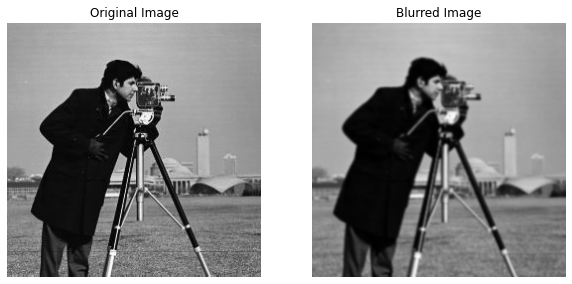

In [13]:
image = nd.array(plt.imread('../data/images/cameraman.jpg')[:, :, 0], device=nd.opencl())
blurred = image.conv2(blur_kernel7)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image.numpy(), cmap='gray')
axes[0].axis(False)
axes[0].set_title('Original Image')
axes[1].imshow(blurred.numpy(), cmap='gray')
axes[1].axis(False)
axes[1].set_title('Blurred Image');

After applying convolution with the $7\times 7$ Gaussian blur kernel, the image on the left becomes blurred as seen on the right.

## Discussion

### The OpenCL Development Process

Developing OpenCL programs follows a similar process to the CUDA development workflow. The outlines is as follows:

1. Write Kernel Programs
2. Write Wrapper Code for the Kernel Program
3. Define Memory Objects that Get Passed into the Program
4. Execute the Wrapper Function

<a href="https://www.khronos.org/registry/OpenCL/sdk/2.2/docs/man/html/">
<img src="https://i.imgur.com/o7GcpCU.png" alt="OpenCL Development Flow" style="width: 60%;  display: block; margin-left: auto; margin-right: auto;"/>
</a>

#### Kernel Program

We'll use elementwise addition through this description. In the kernel function below, the first thing we notice that it is specified as a string. This is a "feature" not a "bug" in that OpenCL compiles the kernel functions at runtime to target different hardware devices. This comes with its own pros and cons in terms of the developeer experience which we'll note below. The kernel function is defined as such with the `__kernel` specifier. The `__global` tag notes that those variables are to be accessible across all OpenCL threads. We also note the `get_global_id` function which fetches the block and thread id. This id is often used in computations to make sure that we do not overwrite information across threads. In this case we use it as the index of the output array.

```C++
std::string ewiseadd_source =
"__kernel void ewiseadd(__global float* a, __global float* b, __global float* out, unsigned int size) {"
"  size_t gid = get_global_id(0);"
"  if (gid < size) out[gid] = a[gid] + b[gid];"
"}";
```

#### Kernel Wrapper and Memory Objects

In this snippet, we compile the element wise add kernel function into a "kernel functor" which is used in the wrapper function `EwiseAdd`. Here we note the use of a custom struct OpenCLArray. This is just a convenience wrapper around the the OpenCL [`cl::Buffer`](https://github.khronos.org/OpenCL-CLHPP/classcl_1_1_buffer.html) object. The functor is a convenicne method that automatically deals with a lot of boiler plate code such as finding available OpenCL devices, setting up an OpenCL context, and setting up an OpenCL Command Queue. When we call ewiseadd, the command is automatically queued up int the default command queue.

```C++
const cl::Program ewiseadd_program(ewiseadd_source, true);
auto ewiseadd = cl::make_kernel<cl::Buffer, cl::Buffer, cl::Buffer, unsigned int>(
  ewiseadd_program, "ewiseadd"
);
void EwiseAdd(OpenCLArray* a, OpenCLArray* b, OpenCLArray* out) {
  OpenCLDims dims(out->size);
  cl::EnqueueArgs eargs(dims.global, dims.local);
    ewiseadd(eargs, a->mem, b->mem, out->mem, (unsigned int)out->size).wait();
```

#### Execute the Wrapper Function

Lastly, we note a small snippet of `pybind` code that exposes the kernel function to `Python` callers. The `OpenCLArray` convenience class is a shim against the underlying data with which python interacts.

```C++
PYBIND11_MODULE(ndarray_backend_opencl, m) {
  namespace py = pybind11;
  using namespace simple_ml;
  using namespace opencl;

  py::class_<OpenCLArray>(m, "Array")
    .def(py::init<size_t>(), py::return_value_policy::take_ownership)
    .def_readonly("size", &OpenCLArray::size);
  
  m.def("ewise_add", EwiseAdd);
}
```

### Speeding up Convolution Operations by Porting from Python

By porting the code from Python to C++, we take advatantage of the speedups that are offered by 1) not having to deal with the overhead of a Python executable 2) The GPU parallelism that both CUDA and OpenCL. While the Python implementation of [`im2col`](https://en.wikipedia.org/wiki/Toeplitz_matrix#Discrete_convolution) is quite efficient theoretically, we can achieve performance gains even with a more naive implementation of Convolution. The CUDA implementation is a bit more terse than the CPU or OpenCL implementation, and we note it below for illustration purposes.

The below implementation has some similar traits to the earlier kernel implementation that we saw. We see a `gid`, though here we have to calculate it (this is configured through the kernel call by `dim.grid` and `dim.block`). We convert the gid into indexes into the a matrix. We then loop over all the dimensions on each thread that computes the convolution. Note that the `a` tensor has a shape of `N H W C_in` and the kernel has a shape of `K K C_in C_out`. The convolutions occur over the `H` and the `W` dimensions and we sum over the `C_in` dimension. We also handle strided convolution by modifying the slicing of `a` and handle the change in output dimensions. We will look into more detail the performance of this optimization in the Experiments section.

```C++
__global__ void Convolution4Kernel(const scalar_t* a, const scalar_t* kernel,
scalar_t* out, size_t size, uint32_t N, uint32_t H, uint32_t W, uint32_t C_in,
uint32_t C_out, uint32_t K, uint32_t stride)
{
    size_t gid = blockIdx.x * blockDim.x + threadIdx.x;
    if (gid < size){
        // compute conv out shape
        size_t out_rows = (H - K) / stride + 1;
        size_t out_cols = (W - K) / stride + 1;

        // get row cols from grid index
        size_t prod = size;
        size_t remainder = gid;

        prod /= N;
        int batch = remainder/prod;
        remainder %= prod;

        prod /= out_rows;
        int outrow = remainder/prod;
        remainder %= prod;

        prod /= out_cols;
        int outcol = remainder/prod;
        remainder %= prod;

        prod /= C_out;
        int chout = remainder/prod;

        float sum = 0;
        for(size_t chin=0; chin < C_in; chin++){
            for(size_t k1=0; k1 < K; k1++){
                for(size_t k2=0; k2 < K; k2++) {
                    sum += kernel[
                        k1 * C_out * C_in * K
                        + k2 * C_out * C_in
                        + chin * C_out
                        + chout
                    ] * a[
                        batch * C_in * W * H
                        + (outrow * stride + k1)  * C_in * W
                        + (outcol * stride + k2) * C_in
                        + chin
                    ];
                }
            }
        }
        // out[
        //     batch * C_out *  out_cols * out_rows
        //     + outrow * C_out * out_cols
        //     + outcol * C_out
        //     + chout
        // ]
        out[gid] = sum;
    }
}

void Convolution4(const CudaArray& a, const CudaArray& kernel, CudaArray* out,
uint32_t N, uint32_t H, uint32_t W, uint32_t C_in, uint32_t C_out, uint32_t K,
uint32_t stride) {
  CudaDims dim = CudaOneDim(out->size);
  Convolution4Kernel<<<dim.grid, dim.block>>>(a.ptr, kernel.ptr, out->ptr,
  out->size, N, H, W, C_in, C_out, K, stride);
}
```

## Experiments
In order to demonstrate our implementation of OpenCL backend, we ran experiments where the same inputs are used but the backends differ. We plotted the distributions of computing times among the backends.
### Binary Operations
For each of the following operations, we created two random `simple_ml` arrays/tensors for each of the two shapes, one small $(64, 32)$ and one large $(2048, 1024)$:
* `EwiseAdd`
* `EwiseMul`
* `Matmul`

For each backend, we repeated the operations of small shapes 10000 times and those of large shapes 100 times (except for `Matmul`, only 20 times). We timed all the repeated operations for all backends. We then plotted the distribution of computing times across the repeated instances for each operation, shape, and backend on a logarithmic scale.

In [16]:
def time_binary(f, devices, shape, N, requires_tensor=False):
  results = {str(device).replace('0', ''): np.empty(N) for device in devices}
  results['numpy'] = np.empty(N)
  for i in tqdm(range(N)):
    a = np.random.randn(*shape)
    b = np.random.randn(*shape)
    t = time.time()
    c = f(a, b)
    results['numpy'][i] = time.time() - t
    for device in devices:
      if requires_tensor:
        a_device = sm.Tensor(a, device=device)
        b_device = sm.Tensor(b, device=device)
      else:
        a_device = nd.array(a, device=device)
        b_device = nd.array(b, device=device)
      t = time.time()
      c_device = f(a_device, b_device)
      results[str(device).replace('0', '')][i] = time.time() - t
  return results

In [19]:
def plot_binary(f, name, size='large', N=None, requires_tensor=False):
  # devices = [nd.cpu(), nd.numpy_device(), nd.cuda(), nd.opencl()]
  # tensor_devices = [sm.cpu(), sm.numpy_device(), sm.cuda(), sm.opencl()]
  devices = [nd.cpu(), nd.numpy_device(), nd.opencl()]
  tensor_devices = [sm.cpu(), sm.numpy_device(), sm.opencl()]
  if size == 'large':
    shape = (2048, 1024)
    if not N:
      N = 100
  else:
    shape = (64, 32)
    if not N:
      N = 10000
  if requires_tensor:
    results = time_binary(f, tensor_devices, shape, N, True)
  else:
    results = time_binary(f, devices, shape, N, False)
  sns.distplot(np.log(results['numpy']), hist=False, label='Native NumPy')
  sns.distplot(np.log(results['numpy_device()']), hist=False, label='NumPy Device')
  sns.distplot(np.log(results['cpu()']), hist=False, label='CPU')
  sns.distplot(np.log(results['opencl()']), hist=False, label='OpenCL')
  # sns.distplot(np.log(results['cuda()']), hist=False, label='CUDA')
  plt.title(name + ' ' + str(shape))
  plt.xlabel('Log Time')
  plt.legend()

100%|██████████| 10000/10000 [00:16<00:00, 614.38it/s]


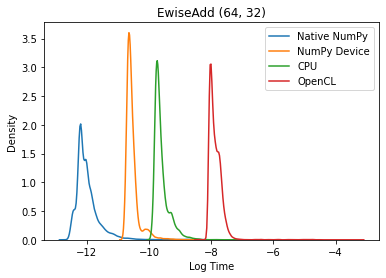

In [20]:
plot_binary(lambda a, b: a + b, 'EwiseAdd', 'small')

For arrays with small sizes, we see that using OpenCL backend is actually the slowest, with CUDA being the second slowest. This fact may not be surprising as when an array's size is small, the total computing time is dominated by the overheads, such as copying data to and from the hardware accelerator. `numpy`is the fastest here because it runs natively on the Python interpreter where this notebook runs. The parallel capabilities of hardware accelerators are not well represented by this experiment.

100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


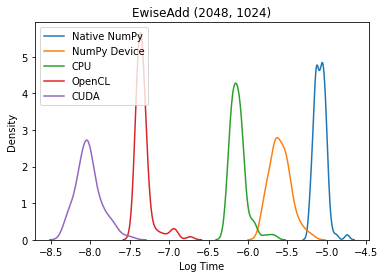

In [18]:
plot_binary(lambda a, b: a + b, 'EwiseAdd', 'large')

For arrays with large sizes, we can see that the ranks are almost reversed. `numpy`, which is the fastest when the sizes are small, becomes the slowest. CUDA becomes the fastest by a wide margin, as we expect. OpenCL is more than twice as fast as CPU. As the array sizes become larger, the relative importance of the overheads becomes less relevant as the actual computations happening in the hardware accelerators dominate.

Another observation we have is that the computing times of OpenCL are more consistent than those of others.

100%|██████████| 10000/10000 [00:12<00:00, 829.50it/s]


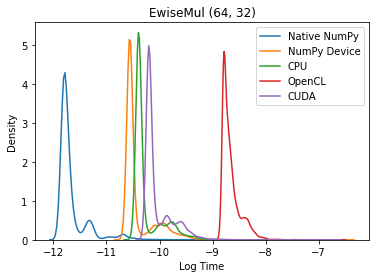

In [19]:
plot_binary(lambda a, b: a * b, 'EwiseMul', 'small')

We observe similar trends as above in `EwiseAdd`.

100%|██████████| 100/100 [00:22<00:00,  4.38it/s]


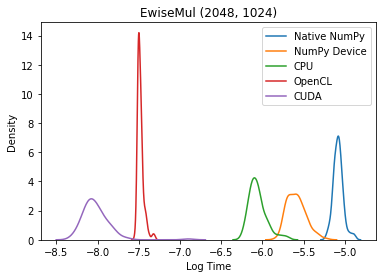

In [20]:
plot_binary(lambda a, b: a * b, 'EwiseMul', 'large')

Again, similar trends are observed. The computing times for OpenCL are shown to be highly consistent.

100%|██████████| 10000/10000 [00:33<00:00, 297.71it/s]


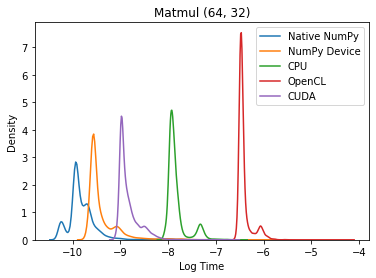

In [21]:
plot_binary(lambda a, b: a @ b.transpose(), 'Matmul', 'small', requires_tensor=True)

For `Matmul`, the difference among backends becomes more pronounced.

100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


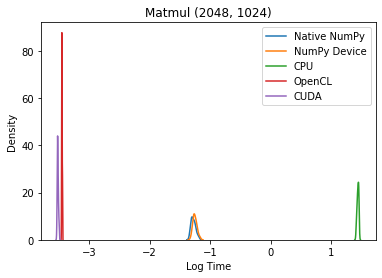

In [22]:
plot_binary(lambda a, b: a @ b.transpose(), 'Matmul', 'large', N=20, requires_tensor=True)

Since `Matmul` is computationally intensive, the benefit of parallelism is clearly shown here. Also note that the computing times are extremely consistent for OpenCL.

As a general trend, OpenCL is faster than CPU and Numpy, but not as fast as CUDA. This is partly due to CUDA being optimized for Nvidia hardware. OpenCL computation time consistency is similar to CUDA.

|| OpenCL | CUDA | CPU |
| --- | --- | --- | --- |
| Speed | Fast | Very fast | Slow |
| Speed consistency | Very consistent | Not very consistent | Consistent |

### Convolutions

Similar to the experiments for binary operations, we used random `simple_ml` arrays of small and large shapes for the images. We chose the $7\times 7$ Gaussian blur kernel as the kernel. Again, we repeated 10000 times for the small shapes and 100 times for the large ones for each of the backends for which we implemented native convolution, i.e. OpenCL, CUDA, and CPU. We then plotted the distribution of computing times across the repeated instances for each shape and backend on a logarithmic scale.

In [23]:
def time_conv(devices, shape, N):
  results = {str(device).replace('0', ''): np.empty(N) for device in devices}
  results['numpy'] = np.empty(N)
  for i in tqdm(range(N)):
    a = np.random.randn(*shape)
    b = blur_kernel7
    for device in devices:
      a_device = nd.array(a, device=device)
      b_device = nd.array(b, device=device)
      t = time.time()
      c_device = a_device.conv2(b_device)
      results[str(device).replace('0', '')][i] = time.time() - t
  return results

In [24]:
def plot_conv(size='large', N=None):
  devices = [nd.cpu(), nd.cuda(), nd.opencl()]
  if size == 'large':
    shape = (2048, 1024)
    if not N:
      N = 100
  else:
    shape = (64, 32)
    if not N:
      N = 10000
  results = time_conv(devices, shape, N)
  sns.distplot(np.log(results['cpu()']), hist=False, label='CPU')
  sns.distplot(np.log(results['opencl()']), hist=False, label='OpenCL')
  sns.distplot(np.log(results['cuda()']), hist=False, label='CUDA')
  plt.title('Convolution ' + str(shape))
  plt.xlabel('Log Time')
  plt.legend()

100%|██████████| 10000/10000 [00:12<00:00, 798.84it/s]


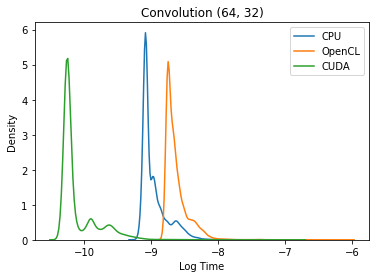

In [25]:
plot_conv('small')

Unlike in the binary operations, we observe that CUDA is faster than CPU for small sizes. OpenCL continues to be the slowest because of computational overheads.

100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


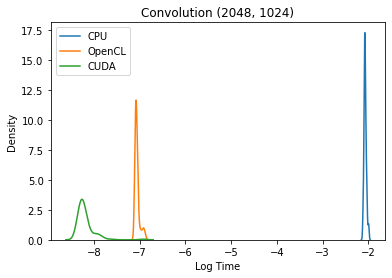

In [26]:
plot_conv('large')

For large sizes, we clearly see CUDA and OpenCL are much faster than CPU. OpenCL again shows highly consistent computing times.

### ResNet

We used ResNet as a real-world example to demonstrate our implementation in training deep neural networks. There are two sets of experiments: one set using native convolution operations and the other using Python-based operations.

In each set, we trained 10 epochs for CUDA and OpenCL backends and 3 epochs for CPU backend using CIFAR-10 training set and evaluated using CIFAR-10 validation set. We recorded the training trajectories for each experiment, which consist of computing time, training accuracy, training loss, validation accuracy, and validation loss for each epoch.

Training took place on Google Colab with Colab Pro subscription on Nvidia's Tesla K80 GPUs.

In [27]:
# import importlib
# importlib.reload(sys.modules['simple_ml'])
# import simple_ml as sm
# importlib.reload(sys.modules['simple_training'])
# from simple_training import train_cifar10, evaluate_cifar10

In [9]:
def training(device=sm.cuda(), model=ResNet9, n_epochs=3):
  train_dataset = sm.data.CIFAR10Dataset("../data/cifar-10-batches-py", train=True)
  val_dataset = sm.data.CIFAR10Dataset("../data/cifar-10-batches-py", train=False)
  train_dataloader = sm.data.DataLoader(
          dataset=train_dataset,
          batch_size=128,
          shuffle=True,
          collate_fn=sm.data.collate_ndarray,
          device=device,
          dtype="float32")
  val_dataloader = sm.data.DataLoader(
          dataset=val_dataset,
          batch_size=128,
          shuffle=True,
          collate_fn=sm.data.collate_ndarray,
          device=device,
          dtype="float32")
  model = model(device=device, dtype="float32")

  return train_cifar10(model, train_dataloader, val_dataloader, n_epochs=n_epochs, optimizer=sm.optim.Adam, lr=0.001, weight_decay=0.001)

In [ ]:
_, _, cuda_trajectories_new = training(device=sm.cuda(), model=ResNet94, n_epochs=10)

In [12]:
_, _, opencl_trajectories_new = training(device=sm.opencl(), model=ResNet94, n_epochs=10)

KeyboardInterrupt: 

In [ ]:
_, _, cpu_trajectories_new = training(device=sm.cpu(), model=ResNet94, n_epochs=3)

In [ ]:
_, _, cuda_trajectories = training(device=sm.cuda(), n_epochs=10)

In [ ]:
_, _, opencl_trajectories = training(device=sm.opencl(), n_epochs=10)

In [ ]:
_, _, cpu_trajectories = training(device=sm.cpu(), n_epochs=3)

We plotted training accuracies, training losses, validation accuracies, and validation losses against number of epochs.

In [35]:
def plot_trajectories(trajectories):
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))
  axes[0].plot(range(1, 11), trajectories['train_acc'], label='training')
  axes[0].plot(range(1, 11), trajectories['val_acc'], label='validation')
  axes[0].set_xlabel('Epoch')
  axes[0].set_xticks(range(1, 11))
  axes[0].set_ylabel('Accuracy')
  axes[0].legend()
  axes[1].plot(range(1, 11), trajectories['train_loss'], label='training')
  axes[1].plot(range(1, 11), trajectories['val_loss'], label='validation')
  axes[1].set_xlabel('Epoch')
  axes[1].set_xticks(range(1, 11))
  axes[1].set_ylabel('Loss')
  axes[1].legend()

For CUDA:

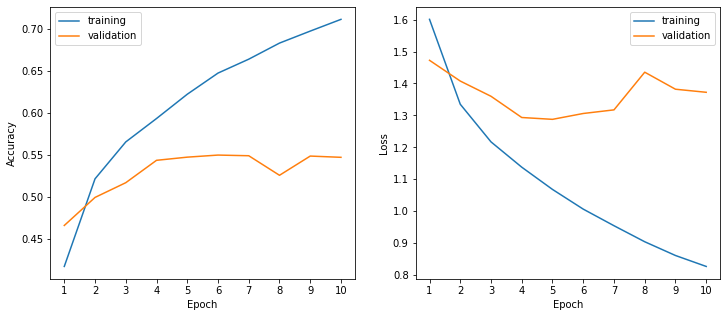

In [36]:
plot_trajectories(cuda_trajectories)

For OpenCL:

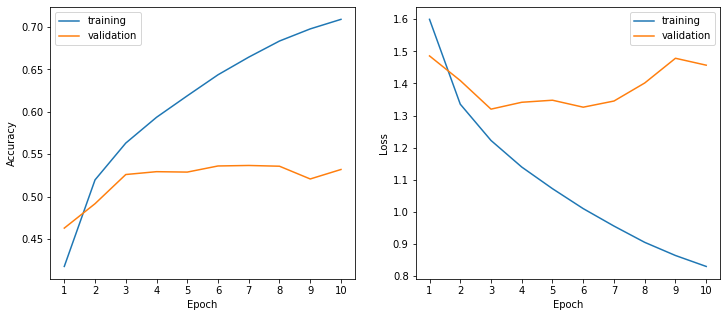

In [37]:
plot_trajectories(opencl_trajectories)

For CUDA using native operations:

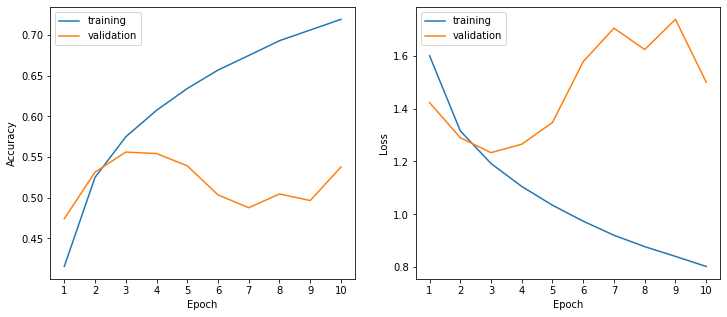

In [40]:
plot_trajectories(cuda_trajectories_new)

For OpenCL using native operations:

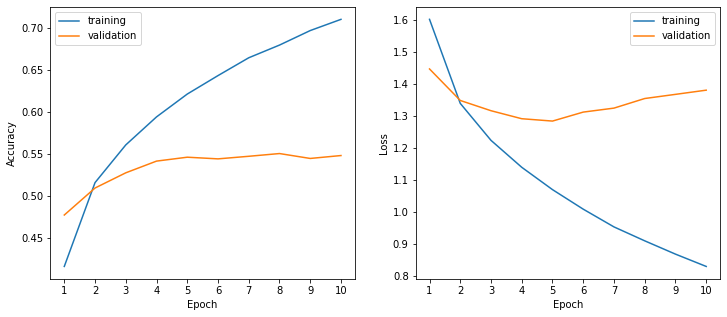

In [41]:
plot_trajectories(opencl_trajectories_new)

We can observe that there is no difference among the trajectories barring randomization in training, showing that switching from CUDA to OpenCL does not affect the training behavior.

We then plotted training accuracies, training losses, validation accuracies, and validation losses against training times.



In [42]:
def plot_comparisons(cuda_trajectories, opencl_trajectories, cpu_trajectories):
  fig, axes = plt.subplots(2, 2, figsize=(12, 10))
  axes[0][0].plot(cuda_trajectories['elapsed_time'], cuda_trajectories['train_acc'], label='CUDA')
  axes[0][0].plot(opencl_trajectories['elapsed_time'], opencl_trajectories['train_acc'], label='OpenCL')
  axes[0][0].plot(cpu_trajectories['elapsed_time'], cpu_trajectories['train_acc'], label='CPU')
  axes[0][0].set_xlabel('Time (s)')
  axes[0][0].set_ylabel('Training Accuracy')
  axes[0][0].legend()
  axes[0][1].plot(cuda_trajectories['elapsed_time'], cuda_trajectories['val_acc'], label='CUDA')
  axes[0][1].plot(opencl_trajectories['elapsed_time'], opencl_trajectories['val_acc'], label='OpenCL')
  axes[0][1].plot(cpu_trajectories['elapsed_time'], cpu_trajectories['val_acc'], label='CPU')
  axes[0][1].set_xlabel('Time (s)')
  axes[0][1].set_ylabel('Validation Accuracy')
  axes[0][1].legend()
  axes[1][0].plot(cuda_trajectories['elapsed_time'], cuda_trajectories['train_loss'], label='CUDA')
  axes[1][0].plot(opencl_trajectories['elapsed_time'], opencl_trajectories['train_loss'], label='OpenCL')
  axes[1][0].plot(cpu_trajectories['elapsed_time'], cpu_trajectories['train_loss'], label='CPU')
  axes[1][0].set_xlabel('Time (s)')
  axes[1][0].set_ylabel('Training Loss')
  axes[1][0].legend()
  axes[1][1].plot(cuda_trajectories['elapsed_time'], cuda_trajectories['val_loss'], label='CUDA')
  axes[1][1].plot(opencl_trajectories['elapsed_time'], opencl_trajectories['val_loss'], label='OpenCL')
  axes[1][1].plot(cpu_trajectories['elapsed_time'], cpu_trajectories['val_loss'], label='CPU')
  axes[1][1].set_xlabel('Time (s)')
  axes[1][1].set_ylabel('Validation Loss')
  axes[1][1].legend()

Using Python convolution operations:

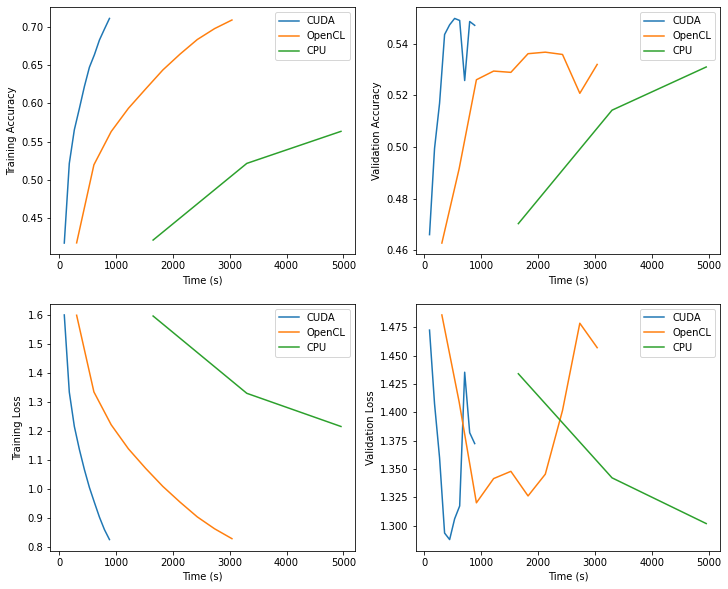

In [43]:
plot_comparisons(cuda_trajectories, opencl_trajectories, cpu_trajectories)

Using native convolution operations:

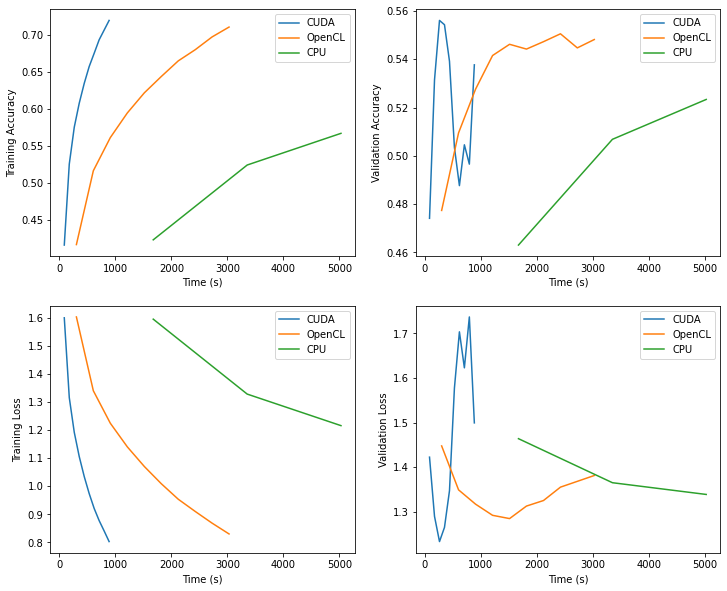

In [44]:
plot_comparisons(cuda_trajectories_new, opencl_trajectories_new, cpu_trajectories_new)

We see that while CUDA is the clear leader, OpenCL follows closely. They are both better than CPU by wide margins. Note that in the plots above, both CUDA and OpenCL were run for 10 epochs; CPU was only run for 3.

We then compared the performance of our implementation of native convolution operations to Python operations by juxtaposing their trajectories for CUDA and for OpenCL.

In [45]:
def plot_comparisons_within(trajectories, trajectories_new):
  fig, axes = plt.subplots(2, 2, figsize=(12, 10))
  axes[0][0].plot(trajectories['elapsed_time'], trajectories['train_acc'], label='Python')
  axes[0][0].plot(trajectories_new['elapsed_time'], trajectories_new['train_acc'], label='Native')
  axes[0][0].set_xlabel('Time (s)')
  axes[0][0].set_ylabel('Training Accuracy')
  axes[0][0].legend()
  axes[0][1].plot(trajectories['elapsed_time'], trajectories['val_acc'], label='Python')
  axes[0][1].plot(trajectories_new['elapsed_time'], trajectories_new['val_acc'], label='Native')
  axes[0][1].set_xlabel('Time (s)')
  axes[0][1].set_ylabel('Validation Accuracy')
  axes[0][1].legend()
  axes[1][0].plot(trajectories['elapsed_time'], trajectories['train_loss'], label='Python')
  axes[1][0].plot(trajectories_new['elapsed_time'], trajectories_new['train_loss'], label='Native')
  axes[1][0].set_xlabel('Time (s)')
  axes[1][0].set_ylabel('Training Loss')
  axes[1][0].legend()
  axes[1][1].plot(trajectories['elapsed_time'], trajectories['val_loss'], label='Python')
  axes[1][1].plot(trajectories_new['elapsed_time'], trajectories_new['val_loss'], label='Native')
  axes[1][1].set_xlabel('Time (s)')
  axes[1][1].set_ylabel('Validation Loss')
  axes[1][1].legend()

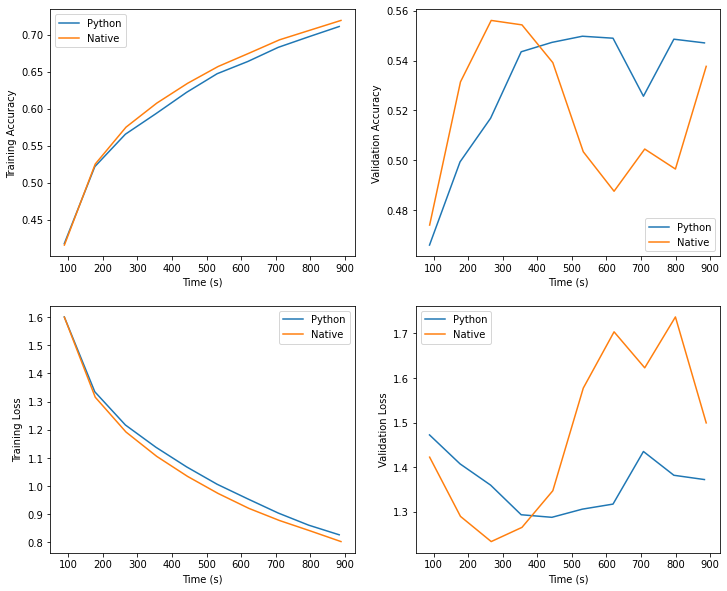

In [46]:
plot_comparisons_within(cuda_trajectories, cuda_trajectories_new)

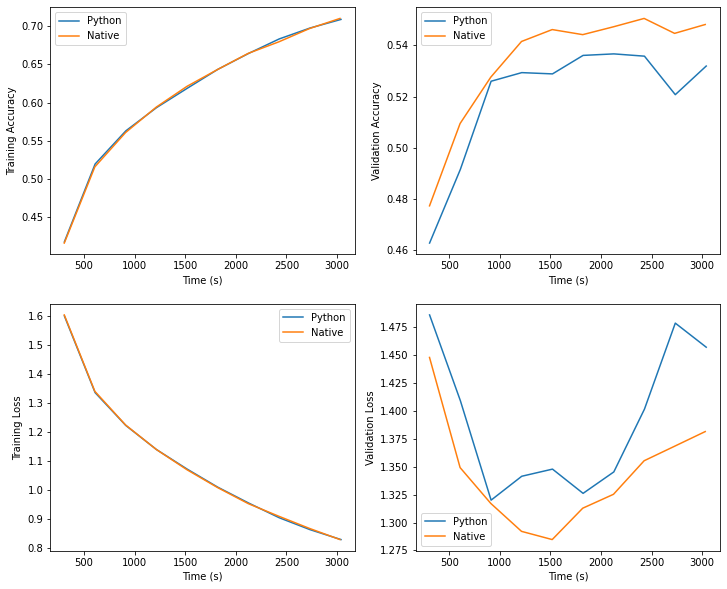

In [47]:
plot_comparisons_within(opencl_trajectories, opencl_trajectories_new)

## Wrapping Up

### Challenges

The OpenCL framework's goal to achieve interoperability across many devices
necessarily sacrifices fitness to specific hardware to some extent. Unlike CUDA
which receives direct support from NVIDIA for its proprietary hardware, OpenCL
does not have an institution dedicated to its active support but largely relies
on the developer community, which itself is not as large as that of CUDA.
 
Another consequence from achieving interoperability is that kernel functions are
compiled only at runtime instead of compile time as in CUDA.  Implementation of
kernels is written as a string passed into wrapper functions, further
complicating our development process. For example, a syntactic error may lie
within the implementation of one of the kernel functions while running make
outputs the binaries without throwing out any errors or warnings; it can only be
caught when we invoke the function in question.
 
In addition, raw memory pointers are not accessible in OpenCL as the hardware
that underlies can have different memory structures. Whereas in CUDA, we can
directly access device memory pointers and call functions, we need to use
wrapper classes and queues for managing memory access and function calls in
OpenCL.

### Conclusion

Our implementation of OpenCL backend for `simple_ml` offers an alternative to CUDA, enabling training of deep neural networks on a larger set of hardware while preserving CUDA's performance to a reasonable extent if run on the same piece of hardware.

Our implementation of native convolution operations speeds up training, which helps mitigate the loss of performance from switching from CUDA to OpenCL.

### Future Directions

There are a couple of directions this project could take to further improve the performance
of the `simple_ml` framework. We note three specific areas:

1. Use the 2d grid model for greater parallelism on both the CUDA and OpenCL backends
2. Implement arbitrary dimension convolution using resizable buffer arrays that pass along the stride information
3. Benchmark the OpenCL implementation on an AMD GPU equivalent to the K80 in the Cloud. (Due to resource constraints this was not possible in this work)

In [48]:
from nbformat import read

# Default path for this notebook
with open("project.ipynb", 'r', encoding='utf-8') as f:
    nb = read(f, 4)

# Count the number of lines in markdown or heading cells
word_count = sum([
    len(cell['source'].replace('#', '').lstrip().split(' '))
    for cell in nb["cells"]
    if cell.cell_type in ["markdown", "heading"]
])

# Count number of lines in the notebook and subtract the number of
# lines in this cell
line_count = sum([
    # Filter out cells that are comments or are empty
    len(list(filter(
        lambda line: not (line.lstrip().startswith("#")),
        cell['source'].split("\n")
    )))
    for cell in nb["cells"]
    if cell.cell_type == "code"
]) - 27

print(f"Word Count: {word_count:,}")
print(f"Line Count: {line_count:,}")

Word Count: 3,210
Line Count: 222
